Using device: cpu
Training set size: 60000
Test set size: 10000
[Epoch 1, Batch 10] Loss: 1.4340, Accuracy: 38.67%
[Epoch 1, Batch 20] Loss: 0.4655, Accuracy: 59.02%
[Epoch 1, Batch 30] Loss: 0.2021, Accuracy: 69.82%
[Epoch 1, Batch 40] Loss: 0.1267, Accuracy: 75.90%
[Epoch 1, Batch 50] Loss: 0.1568, Accuracy: 79.89%
[Epoch 1, Batch 60] Loss: 0.1228, Accuracy: 82.63%
[Epoch 1, Batch 70] Loss: 0.1048, Accuracy: 84.71%
[Epoch 1, Batch 80] Loss: 0.1080, Accuracy: 86.26%
[Epoch 1, Batch 90] Loss: 0.0779, Accuracy: 87.52%
[Epoch 1, Batch 100] Loss: 0.1111, Accuracy: 88.50%
[Epoch 1, Batch 110] Loss: 0.0760, Accuracy: 89.33%
[Epoch 1, Batch 120] Loss: 0.0612, Accuracy: 90.03%
[Epoch 1, Batch 130] Loss: 0.0503, Accuracy: 90.66%
[Epoch 1, Batch 140] Loss: 0.0784, Accuracy: 91.19%
[Epoch 1, Batch 150] Loss: 0.0580, Accuracy: 91.65%
[Epoch 1, Batch 160] Loss: 0.1161, Accuracy: 91.99%
[Epoch 1, Batch 170] Loss: 0.0367, Accuracy: 92.33%
[Epoch 1, Batch 180] Loss: 0.0655, Accuracy: 92.61%
[Epoch 1,

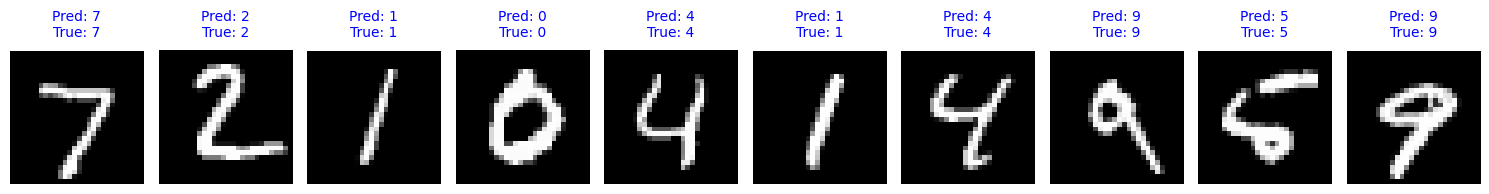

In [1]:
import torch 
import torch.nn as nn  
import torch.nn.functional as F  
import torchvision  
import torchvision.transforms as transforms  
import matplotlib.pyplot as plt  
from PIL import Image 
import torchvision.datasets as datasets  
from torch.utils.data import DataLoader 

# Define the Residual Block
class ResidualBlock(nn.Module):  
    def __init__(self, inchannel, outchannel, stride=1):  
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(  
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),  
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),  
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),  
            nn.BatchNorm2d(outchannel)  
        )
        self.shortcut = nn.Sequential()  
        if stride != 1 or inchannel != outchannel:  
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),  
                nn.BatchNorm2d(outchannel)  # Batch normalization for shortcut
            )

    def forward(self, x):  
        out = self.left(x)  
        out += self.shortcut(x)  
        out = F.relu(out)  
        return out

# Define ResNet with ResidualBlock
class ResNet(nn.Module):  # Defines ResNet model
    def __init__(self, block, num_blocks, num_classes=10):  
        super(ResNet, self).__init__()
        self.in_channels = 64  

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Initial convolution
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)  # First layer
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)  # Second layer
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)  # Third layer
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)  # Fourth layer
        self.fc = nn.Linear(512, num_classes)  # Fully connected output layer

    def _make_layer(self, block, out_channels, num_blocks, stride):  
        strides = [stride] + [1] * (num_blocks - 1)  
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels  
        return nn.Sequential(*layers)

    def forward(self, x):  # Forward pass
        out = F.relu(self.bn1(self.conv1(x)))  # Initial convolution and activation
        out = self.layer1(out)  # Pass through layer 1
        out = self.layer2(out)  # Pass through layer 2
        out = self.layer3(out)  # Pass through layer 3
        out = self.layer4(out)  # Pass through layer 4
        out = F.avg_pool2d(out, 4)  # Average pooling
        out = out.view(out.size(0), -1)  # Flatten feature map
        out = self.fc(out)  # Fully connected layer
        return out

def ResNet18():  # Factory function for ResNet18
    return ResNet(ResidualBlock, [2, 2, 2, 2])  # Standard ResNet18 block configuration

# Device and hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
print("Using device:", device)  # Print selected device
EPOCH = 10  # Number of epochs
BATCH_SIZE = 128  
LR = 0.01  # Learning rate

# Define transformations
transform = transforms.Compose([  
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.1307,), (0.3081,))  
])

# Load MNIST dataset
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)  
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True) 
print("Training set size:", len(trainset))  

testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)  # Test dataset
testloader = DataLoader(testset, batch_size=100, shuffle=False)  
print("Test set size:", len(testset))

# Model, loss, and optimizer
net = ResNet18().to(device)  
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = torch.optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)  

# Training the model with epoch progress display
def train_model():  
    net.train()  
    for epoch in range(EPOCH):  # Loop through epochs
        running_loss = 0.0  
        correct = 0  
        total = 0  

        for i, (inputs, labels) in enumerate(trainloader, start=1):  
            inputs, labels = inputs.to(device), labels.to(device)  
            optimizer.zero_grad()  
            outputs = net(inputs)
            loss = criterion(outputs, labels)  
            loss.backward()  
            optimizer.step()  

            # Update running loss
            running_loss += loss.item()

            # Calculate predictions and accuracy
            _, predicted = torch.max(outputs, 1)  
            correct += (predicted == labels).sum().item()  # Count correct predictions
            total += labels.size(0)  

            # Print progress every 10 batches
            if i % 10 == 0:
                accuracy = 100 * correct / total
                print(f"[Epoch {epoch+1}, Batch {i}] Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")
        
        # Print average loss and accuracy for the epoch
        epoch_accuracy = 100 * correct / total
        print(f"Epoch {epoch+1} completed. Average Loss: {running_loss / len(trainloader):.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Testing the model
def test_model():  # Function to test the model
    net.eval()  
    correct = 0 
    total = 0  
    with torch.no_grad():  
        for inputs, labels in testloader:  # Loop through test batches
            inputs, labels = inputs.to(device), labels.to(device)  
            outputs = net(inputs)  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
    print(f'Test Accuracy: {100 * correct / total:.2f}%')  

# Display predictions and true labels below images
def overlay_predictions_below(images, predictions, true_labels=None):  
    unnormalize = transforms.Normalize(mean=[-0.1307 / 0.3081], std=[1 / 0.3081])  
    images = torch.stack([unnormalize(img) for img in images.cpu()])  
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))  
    for i in range(len(images)):  
        img = transforms.ToPILImage()(images[i])  # Convert tensor to PIL image
        axes[i].imshow(img, cmap='gray')  
        axes[i].axis('off')  # Remove axis
        text = f"Pred: {predictions[i].item()}"  
        if true_labels is not None:  # Add true label if available
            text += f"\nTrue: {true_labels[i].item()}"
        axes[i].set_title(text, fontsize=10, color="blue", pad=10)  
    plt.tight_layout()  
    plt.show()  

# Predict and display results
def predict_and_overlay_test_images(num_images=5):  
    net.eval()  # Set model to evaluation mode
    images, labels = next(iter(testloader))  
    images, labels = images[:num_images].to(device), labels[:num_images].to(device)  
    with torch.no_grad():  
        outputs = net(images)  
        _, predicted = torch.max(outputs, 1)  
    overlay_predictions_below(images, predicted, labels)  

# Predict on user-uploaded image
def predict_user_image(image_path):  
    try:
        user_image = Image.open(image_path).convert('L')  
        transform_user = transforms.Compose([
            transforms.Resize((28, 28)),  # Resize image to 28x28
            transforms.ToTensor(),  
            transforms.Normalize((0.1307,), (0.3081,))  
        ])
        user_image_tensor = transform_user(user_image).unsqueeze(0).to(device)  
        with torch.no_grad():  # Disable gradient calculation
            output = net(user_image_tensor)  # Forward pass
            _, predicted = torch.max(output, 1)
        overlay_predictions_below(user_image_tensor.squeeze(0), predicted)  
    except FileNotFoundError:  
        print(f"Error: File not found at {image_path}")  

# Train and Test
train_model()  
test_model()  

# Display predictions
predict_and_overlay_test_images(num_images=10)  # Display predictions on test images
# predict_user_image('path_to_image')  # This is to predict user input 28*28 dimension image
